# `CLOUD.jl` - 1D linear advection

In [21]:
using CLOUD
using Plots
using OrdinaryDiffEq
plots_path = "../plots/advection_dgsem_1D/"
results_path = "../results/advection_dgsem_1D/";

Define the physical problem (advection of a sine wave)

In [22]:
a = 1.0  # advection velocity
A = 1.0  # amplitude
L = 1.0  # domain length
k = 4*π/L  # wave number
T = 1*L/a  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation(a,λ=1.0);

Set up a strong-form DGSEM-LGL scheme of degree `p` with `M` elements and periodic boundary conditions

In [23]:
M = 4  # number of elements
p = 3  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGSEM(p), Line(), LGLQuadrature())
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation)
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, StrongConservationForm(), 
     (0.0, T), Eager(), results_path, overwrite=true, clear=true);

Run the `OrdinaryDiffEq` solver with RK4, taking `n_s` snapshots

In [24]:
n_s = 10
dt_scale = 0.1
dt = dt_scale*(L/M)/(a*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false, 
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final");

Visualize the solution

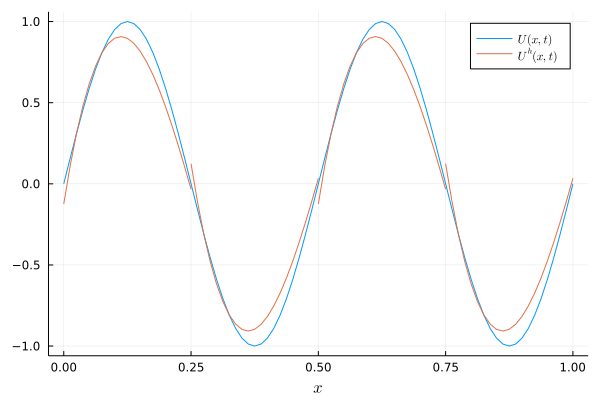

In [25]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(last(sol.u), plotter, "solution.pdf", exact_solution=initial_data,
    label="U^h(x,t)", label_exact="U(x,t)")

Calculate the integral L<sup>2</sup> error norm

In [26]:
error_analysis = ErrorAnalysis(conservation_law, 
    spatial_discretization, 
    results_path)
print("L2 error: ", analyze(error_analysis, last(sol.u), initial_data)[1])

L2 error: 0.09362258244277262